## Implement a global connector for number of protons vs. ionization enthalpy

Rules for new connectors:

+ It must be a subclass of pytc.global_models.GlobalConnector.
+ It must define param_guesses in the class namespace (i.e. at the top of the class definition.) This should have reasonable guesses for the parameters.
+ It must define required_data in the class namespace (i.e. at the top of the class definition.) These are strings that name the attributes of experiment that are required to do the calculation.
+ It must define output methods (like dH) that:
    + take only self and experiment as arguments.
    + use the parameters specified in param_guesses as attributes of self (e.g. self.dH_intrinsic above).
    + access any required information about the experiment from the experiment object.
+ There is no limit to the number of parameters, required data, or output methods.

Full docs:

https://pytc.readthedocs.io/en/latest/writing_new_models.html

In [1]:
%matplotlib inline
import pytc

# Fit successful? True
# 2017-05-16 09:04:34.574310
# Units: cal/mol
# Fit type: maximum likelihood
# AIC: -156.04856236830759
# AICc: -153.29856236830759
# BIC: -129.2272500970654
# F: 236747.46021276896
# Rsq: 0.999954008427029
# Rsq_adjusted: 0.9999497847111439
# df: 99
# ln(L): 88.02428118415379
# num_obs: 108
# num_param: 9
type,name,exp_file,value,stdev,bot95,top95,fixed,guess,lower_bound,upper_bound
global,np_num_H,NA,-9.39633e-01,4.64506e-03,-9.48851e-01,-9.30415e-01,False,1.00000e-01,-inf,inf
global,np_dH_intrinsic,NA,-8.67688e+02,4.69256e+01,-9.60810e+02,-7.74566e+02,False,0.00000e+00,-inf,inf
global,K_global,NA,4.41939e+07,3.84731e+05,4.34305e+07,4.49574e+07,False,1.00000e+06,-inf,inf
local,dilution_intercept,ca-edta/tris-01.DH,-8.77125e-01,6.36933e-02,-1.00352e+00,-7.50727e-01,False,0.00000e+00,-inf,inf
local,fx_competent,ca-edta/tris-01.DH,9.73905e-01,8.75705e-05,9.73731e-01,9.74078e-01,False,1.00000e+00,-inf,inf
local,dilution_heat,ca-edta/tris-01.DH,2.88106e+03,4.44560e+

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


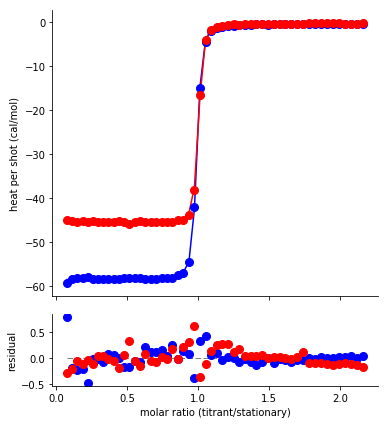

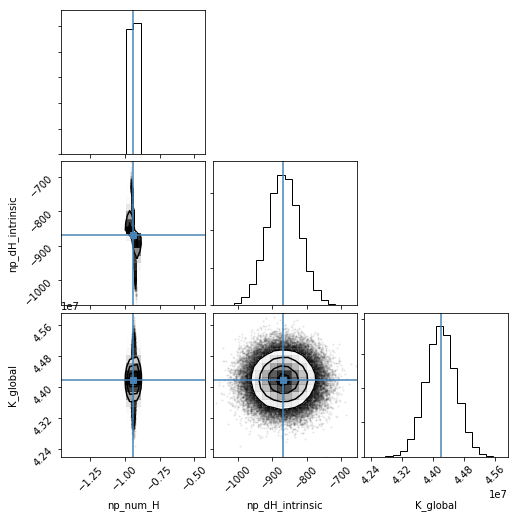

In [4]:
# --------------------------------------------------------------------
# define buffer ionization enthalpies.
# goldberg et al (2002) Journal of Physical and Chemical Reference Data 31 231,  doi: 10.1063/1.1416902
TRIS_IONIZATION_DH = 47.45/4.184*1000 # cal/mol
IMID_IONIZATION_DH = 36.64/4.184*1000 # cal/mol

class MyNumProtons(pytc.GlobalConnector):
    param_guesses = {"num_H":0.1,"dH_intrinsic":0.0}
    required_data = ["ionization_enthalpy"]
    
    def dH(self,experiment):

        return self.dH_intrinsic + self.num_H*experiment.ionization_enthalpy


# --------------------------------------------------------------------
# Create a global fitting instance
g = pytc.GlobalFit()
num_protons = MyNumProtons("np")

# ------------------------------------------------------------------------------------
# Tris buffer experiment

tris = pytc.ITCExperiment("ca-edta/tris-01.DH",pytc.indiv_models.SingleSite,shot_start=2)
tris.ionization_enthalpy = TRIS_IONIZATION_DH

g.add_experiment(tris)
g.link_to_global(tris,"dH",num_protons.dH)
g.link_to_global(tris,"K","K_global")

# ------------------------------------------------------------------------------------
# Imidazole buffer experiment

imid = pytc.ITCExperiment("ca-edta/imid-01.DH",pytc.indiv_models.SingleSite,shot_start=2)
imid.ionization_enthalpy = IMID_IONIZATION_DH

g.add_experiment(imid)
g.link_to_global(imid,"dH",num_protons.dH)
g.link_to_global(imid,"K","K_global")

# --------------------------------------------------------------------
# Do a global fit
g.fit()

# Show the results
fig, ax = g.plot()
c = g.corner_plot()
print(g.fit_as_csv)